In [4]:
# dataset = 'cifar10', model = mobile, CELoss vs middles

from Dataloaders import dataloader_cifar10, dataloader_image_20, dataloader_ccpd

from Models import mobilenetv2, resnet
import torch
models_name = {'mobilenetv2':mobilenetv2, 'resnet':resnet}
datasets_name = {'cifar10':dataloader_cifar10, 'image_20':dataloader_image_20, 'ccpd':dataloader_ccpd}
middle_size_mobile = {x:2**x for x in range(5)}
middle_size_resnet = {x:2**x for x in range(6)}

quantization = False
int_trans = False


Files already downloaded and verified
Files already downloaded and verified


/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


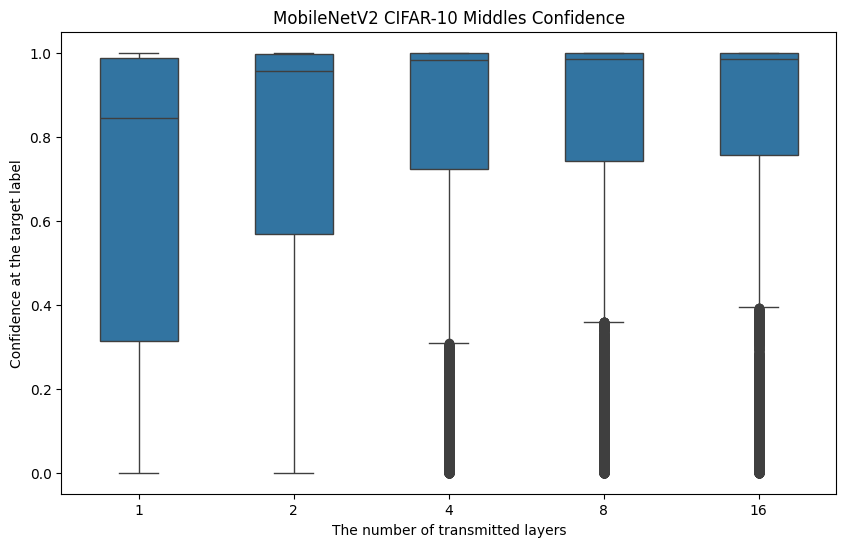

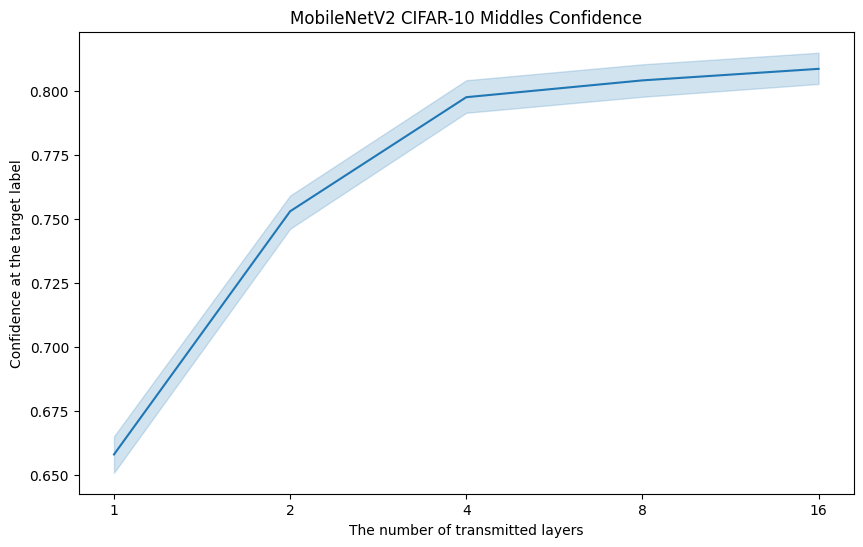

In [5]:
# dataset = 'cifar10', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf['label'] = test.dataset.targets
middles_conf['label'] = middles_conf['label'].apply(lambda x: test.dataset.classes[x])
middles_conf = middles_conf.melt(id_vars='label', var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNetV2 CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(5), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


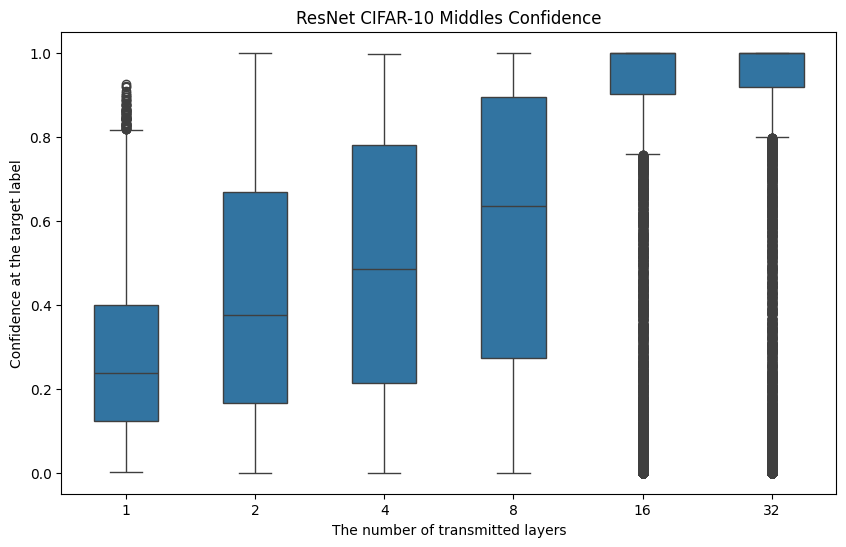

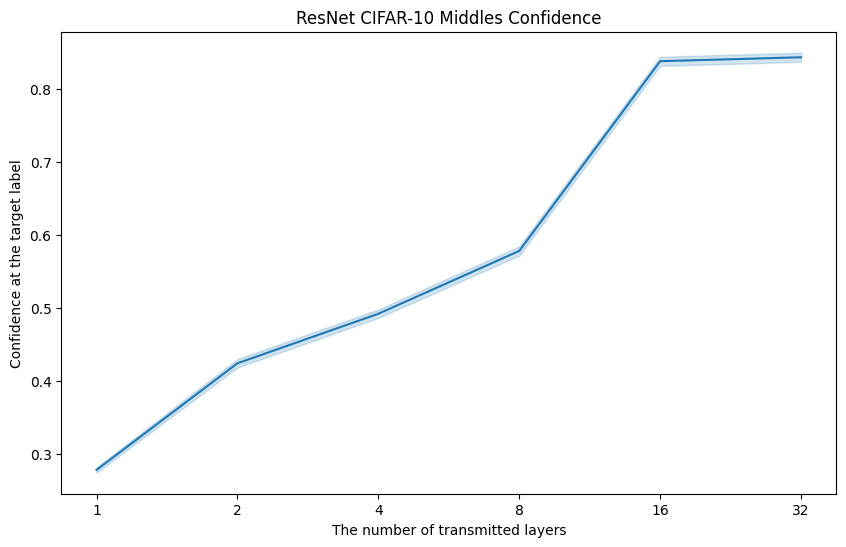

In [6]:
# dataset = 'cifar10', model = resnet, CELoss vs middles
device = 'cuda:0'
client, server = resnet.resnet_splitter(num_classes=10,
                                        weight_root='./Weights/cifar-10',
                                        layers=50)

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_cifar-10_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in enumerate(test):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_resnet]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))
middles_conf['conf'] = middles_conf['conf'].apply(lambda x: float(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('ResNet CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('ResNet CIFAR-10 Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

0it [00:00, ?it/s]/home/tonypeng/anaconda3/envs/iot/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
51it [00:21,  2.37it/s]
51it [00:17,  2.85it/s]
51it [00:17,  2.85it/s]
51it [00:17,  2.87it/s]
51it [00:17,  2.86it/s]
51it [00:17,  2.88it/s]


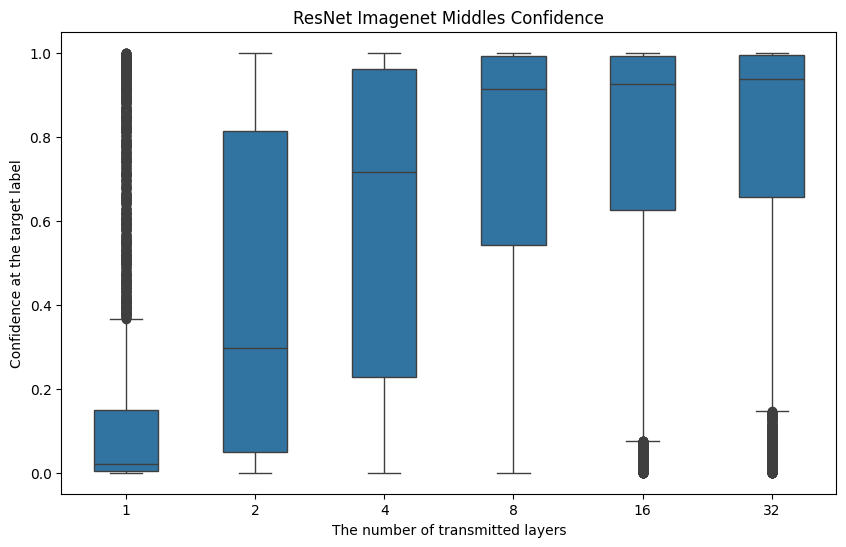

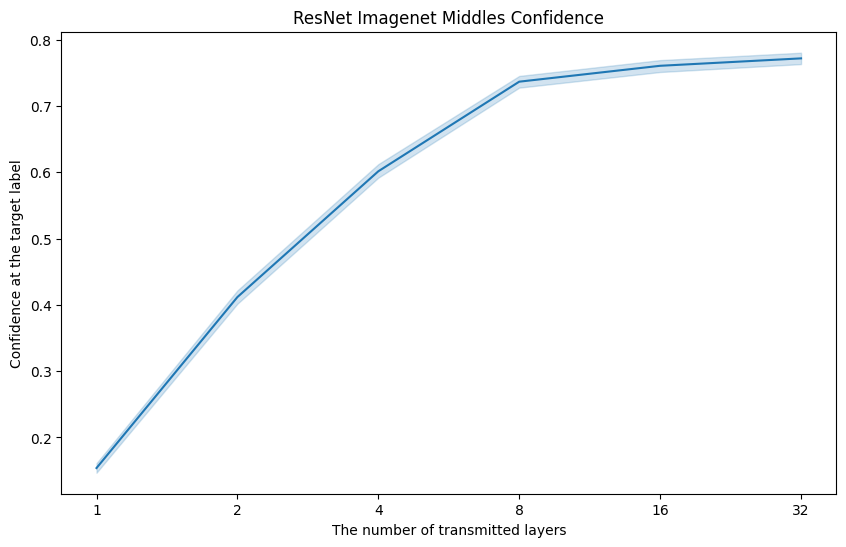

In [7]:
# dataset = 'imagenet', model = resnet, CELoss vs middles
from tqdm import tqdm
device = 'cuda:0'
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target, _) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_resnet]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('ResNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('ResNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_resnet)), [str(x) for x in middle_size_resnet.values()])
plt.ylabel('Confidence at the target label')
plt.show()

51it [00:16,  3.05it/s]
51it [00:16,  3.02it/s]
51it [00:16,  3.07it/s]
51it [00:16,  3.07it/s]
51it [00:16,  3.05it/s]


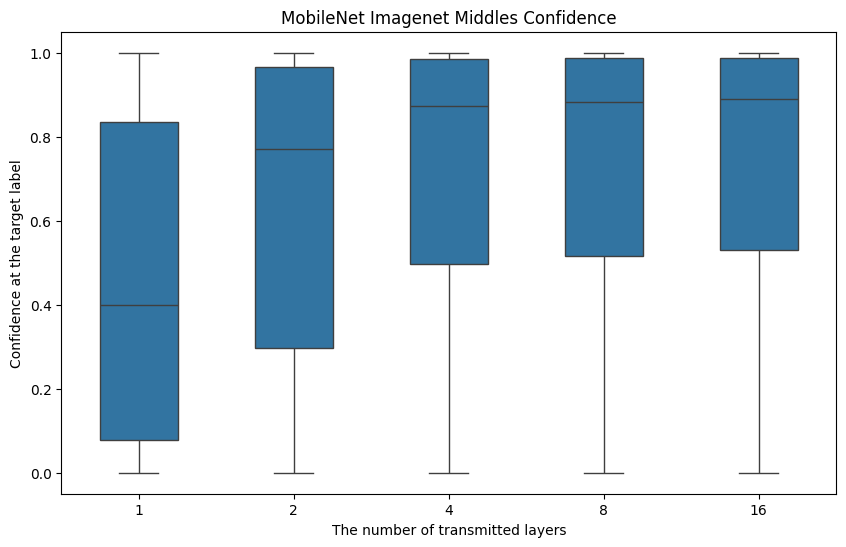

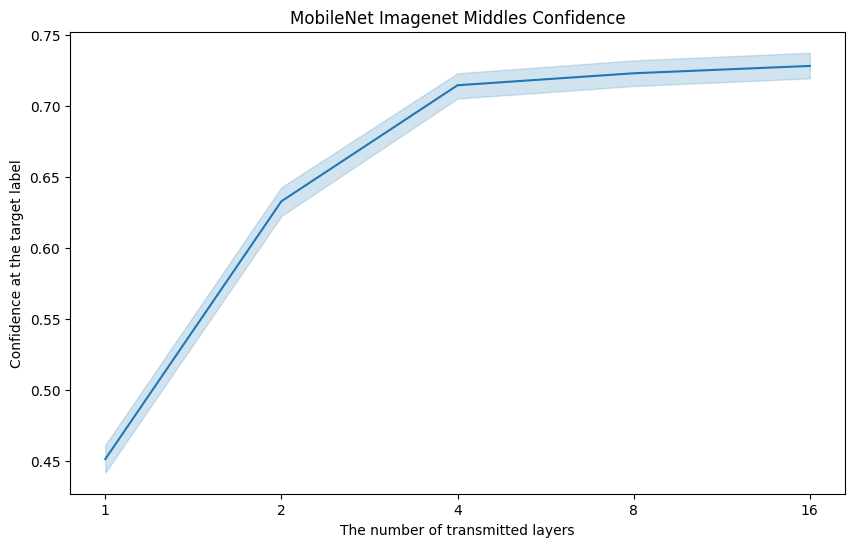

In [8]:
# dataset = 'imagenet', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet')

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_imagenet_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target, _) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNet Imagenet Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [9]:
# dataset = 'imagenet', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet')

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated()

middle_models = []
for i in range (1):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('/home/tonypeng/Downloads/mobile_imagenet_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
with torch.no_grad():
    # get the conf for each middles
    accuracy = [0] * len(middle_models)
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target, _) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = torch.argmax(out, dim=1)
            out = out.eq(target).float()
            count += out.shape[0]
            accuracy[i] += out.sum().item()
    # get the conf for the server   
        accuracy[i] /= count# print the accuracy    

print('MobileNetV2 Imagenet Middles Accuracy')
print('The number of transmitted layers', 'Accuracy')
for i in range(len(middle_models)):
    print(i, accuracy[i])

51it [00:16,  3.12it/s]

MobileNetV2 Imagenet Middles Accuracy
The number of transmitted layers Accuracy
0 0.0


90it [00:12,  7.13it/s]
90it [00:10,  8.96it/s]
90it [00:10,  8.88it/s]
90it [00:10,  8.88it/s]
90it [00:10,  8.90it/s]


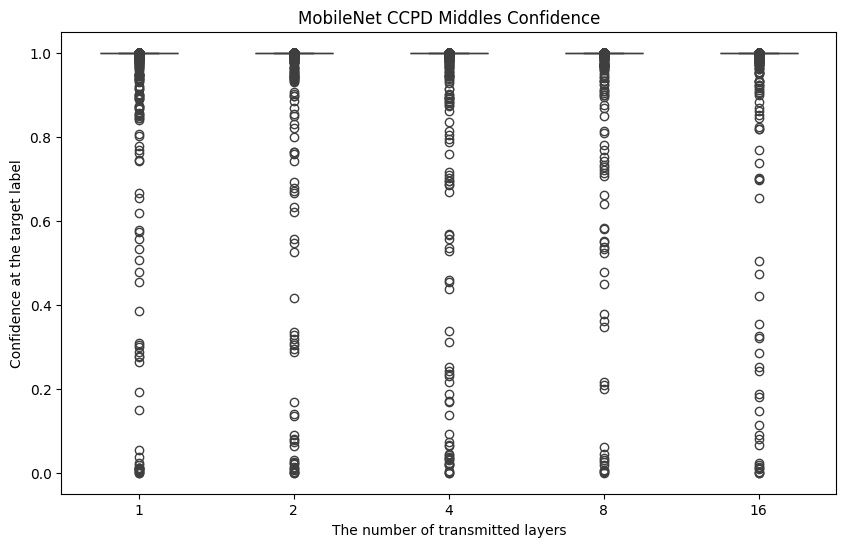

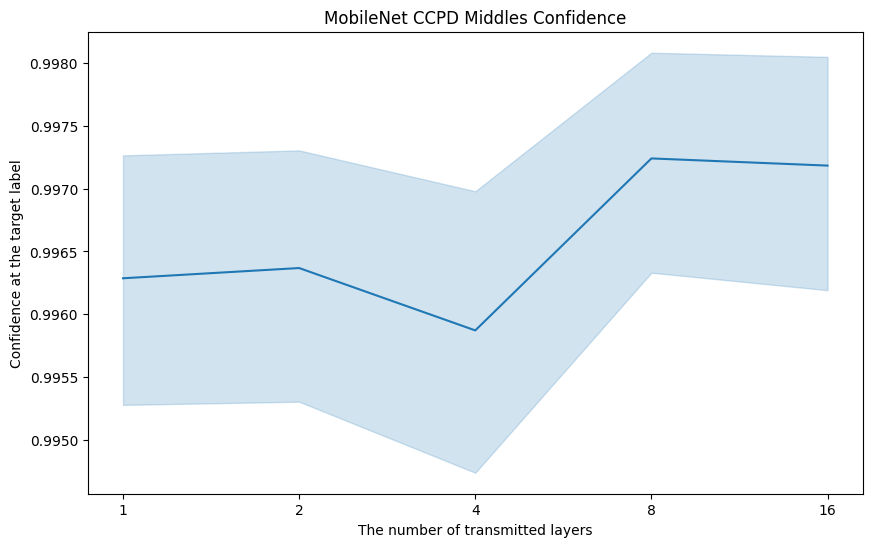

In [10]:
# dataset = 'ccpd', model = mobile, CELoss vs middles
device = 'cuda:0'
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=34,
                                        weight_root='./Weights/ccpd-small/')

_, test, _ = dataloader_ccpd.Dataloader_ccpd_integrated()

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_ccpd_small_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

import torch
import numpy as np
import sys
with torch.no_grad():
    # get the conf for each middles
    middles_conf = np.zeros((len(middle_models), len(test.dataset)))
    for i in range(len(middle_models)):
        count = 0
        for j, (data, target) in tqdm(enumerate(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle_models[i](out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.gather(1, target.view(-1, 1)).view(-1)
            middles_conf[i][count:count+out.shape[0]] = out.cpu().numpy()
            count += out.shape[0]
    # get the conf for the server
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

middles_conf = pd.DataFrame(middles_conf)
middles_conf = middles_conf.T
middles_conf.columns = [str(x) for x in middle_size_mobile]
middles_conf = middles_conf.melt(var_name='middle', value_name='conf')
middles_conf['middle'] = middles_conf['middle'].apply(lambda x: int(x))

plt.figure(figsize=(10, 6))
sns.boxplot(x='middle', y='conf', data=middles_conf, width=0.5)
plt.title('MobileNet CCPD Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='middle', y='conf', data=middles_conf)
plt.title('MobileNet CCPD Middles Confidence')
plt.xlabel('The number of transmitted layers')
plt.xticks(np.arange(len(middle_size_mobile)), [str(x) for x in middle_size_mobile.values()])
plt.ylabel('Confidence at the target label')
plt.show()

In [11]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/')

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
with torch.no_grad():
    # get the conf for each middles
    for i in range(len(middle_models)):
        middle = middle_models[i]
        gate  = gate_models[i]
        for j, (data, target) in enumerate(tqdm(test)):
            data, target = data.to(device), target.to(device)
            out = client(data).detach()
            out = middle.in_layer(out)
            out = float_to_uint(out)
            out = uint_to_float(out)
            out = middle.out_layer(out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            out = out.max(dim=1)[1]
            out = out == target
            gate_results[i].append(out.cpu().numpy())
    # get the conf for the server

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 100/100 [00:00<00:00, 149.08it/s]


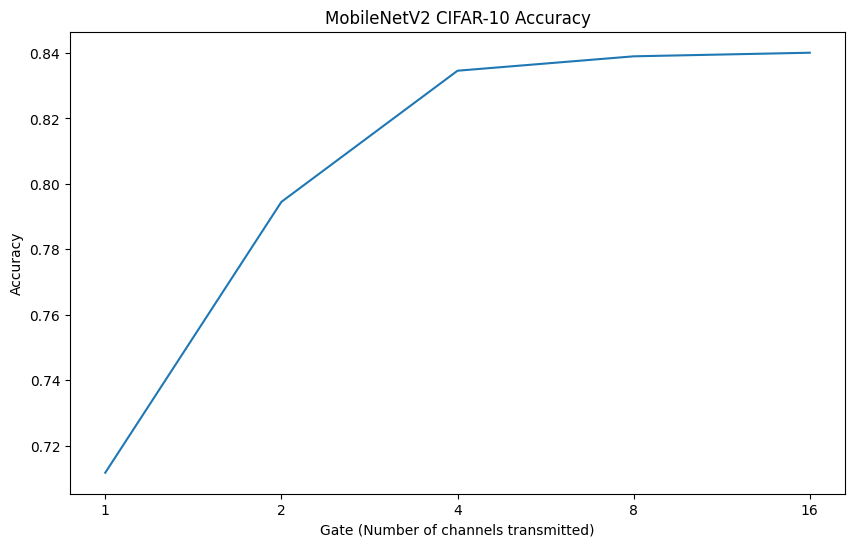

In [12]:
# plot the seaborn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

gate_results = np.array(gate_results)
gate_results = gate_results.reshape(gate_results.shape[0], -1)
gate_results = np.average(gate_results, axis=1)

plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()], gate_results)
plt.title('MobileNetV2 CIFAR-10 Accuracy')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Accuracy')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:45<00:00, 217.79it/s]


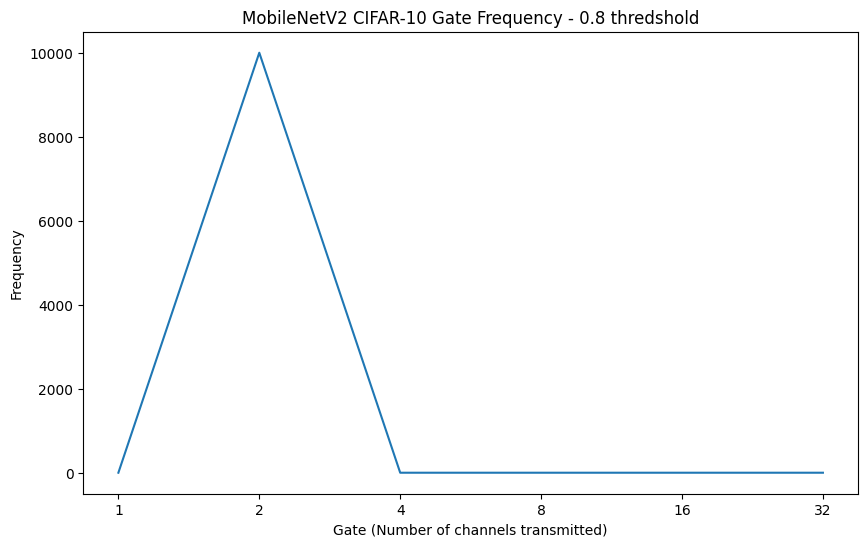

Accuracy: [0.7945]


In [13]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.8
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_080 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_080[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_080 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_080)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.8 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', mobile_cifar_gate_accuracy_080/len(test))  


Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:43<00:00, 228.78it/s]
/tmp/ipykernel_18805/3942536732.py:84: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title('MobileNetV2 CIFAR-10 Gate Frequency - %.2f thredshold'%mobile_cifar_gate_accuracy_075)


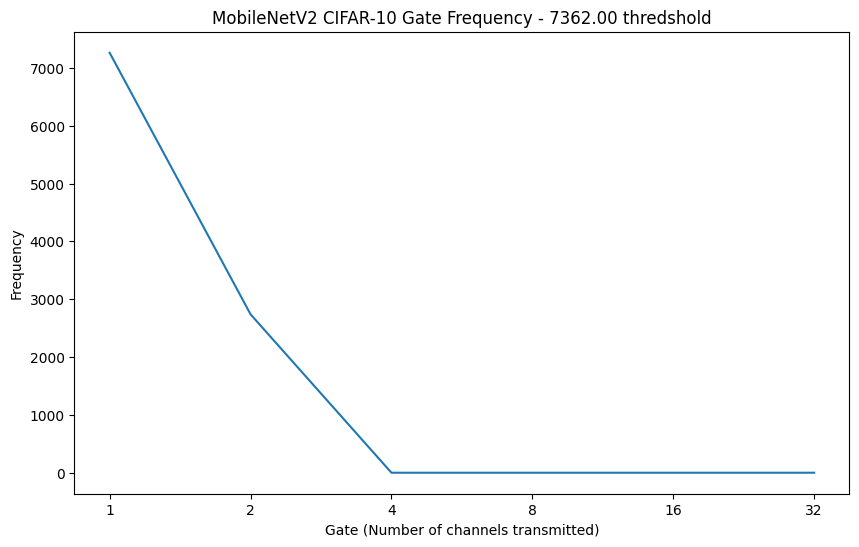

Accuracy: [0.7362]


In [14]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.75
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

mobile_cifar_gate_075 = [] # exit rate here
for i in range(len(gate_models)):
    mobile_cifar_gate_075.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_075 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_075 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_075[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_075[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_075 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_075)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.75 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

print('Accuracy:', mobile_cifar_gate_accuracy_075/len(test))

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:49<00:00, 204.07it/s]


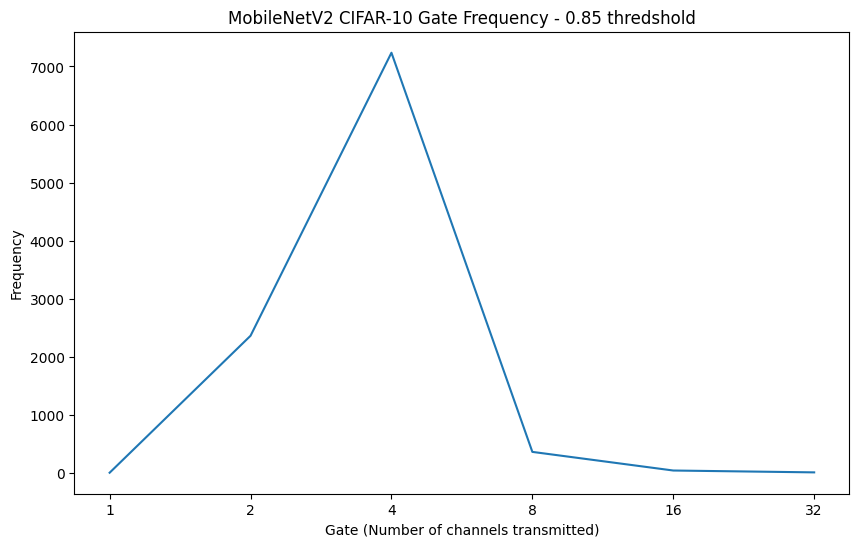

Accuracy: [0.831]


In [15]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.85
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_085 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_085 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_085)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - 0.85 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

print('Accuracy:', mobile_cifar_gate_accuracy_085/len(test))

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 10000/10000 [00:52<00:00, 189.00it/s]


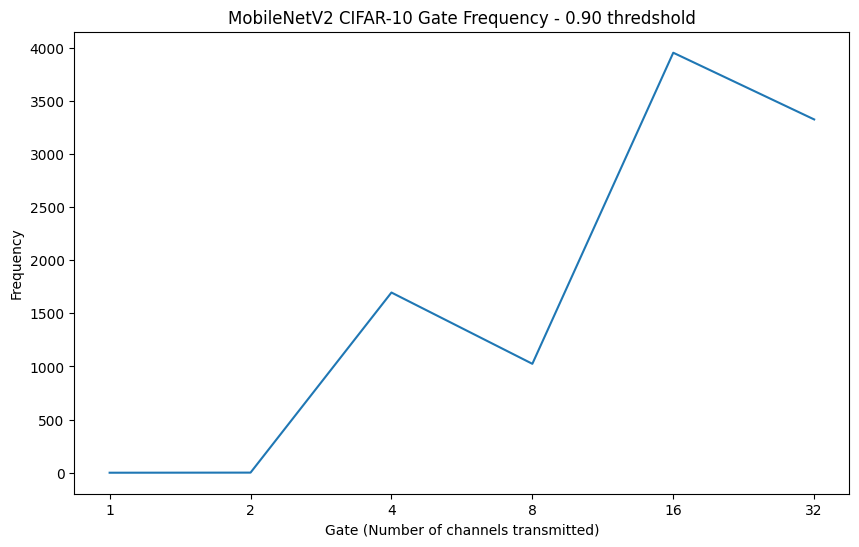

Accuracy: [0.8356]


In [16]:
# dataset = 'cifar10', model = mobile, exit rate vs gate
device = 'cuda:0'
width = 16
height = 16
threshold = 0.9
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_mobile)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_mobile[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/cifar-10/gate/mobile_cifar-10_gate_%s.pth'%str(middle_size_mobile[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
mobile_cifar_gate_frequency_090 = np.zeros(len(gate_models)+1)
mobile_cifar_gate_accuracy_090 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                mobile_cifar_gate_frequency_090[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            mobile_cifar_gate_frequency_090[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        mobile_cifar_gate_accuracy_090 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_090)
plt.title('MobileNetV2 CIFAR-10 Gate Frequency - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

print('Accuracy:', mobile_cifar_gate_accuracy_090/len(test))


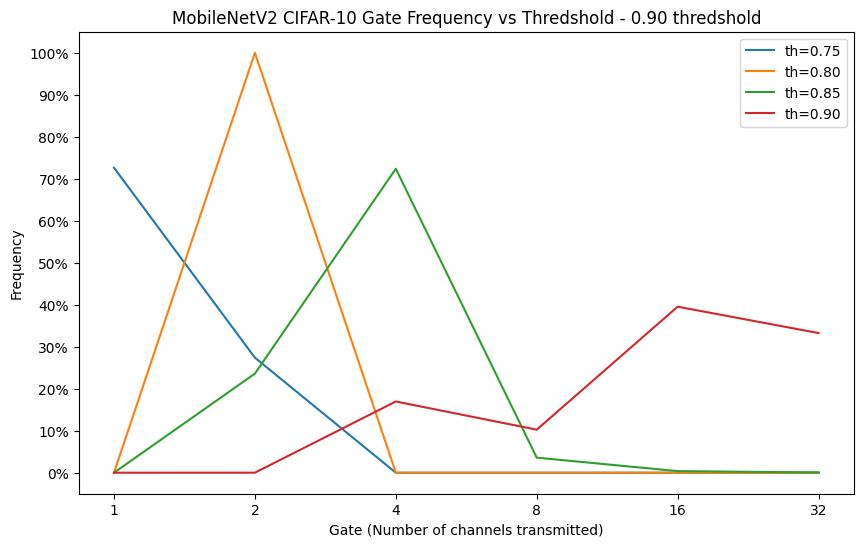

In [17]:
# plot a single image
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_075, label='th=0.75')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_080, label='th=0.80')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_085, label='th=0.85')
plt.plot([str(x) for x in middle_size_mobile.values()]+ [str(2*list(middle_size_mobile.values())[-1])], mobile_cifar_gate_frequency_090, label='th=0.90')

plt.title('MobileNetV2 CIFAR-10 Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])
plt.legend()
plt.show()


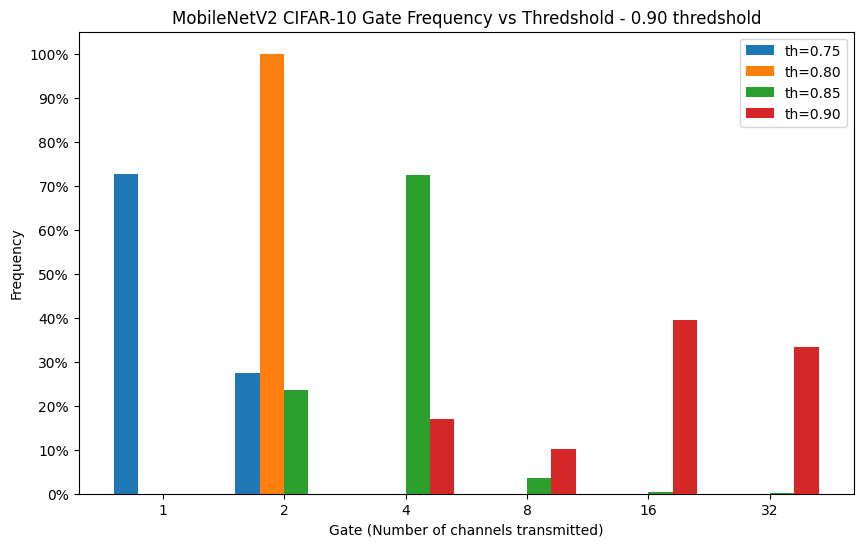

In [18]:
# plot a single image
plt.figure(figsize=(10, 6))
plt.bar([x-0.3 for x in range(len(middle_size_mobile.values())+1)], mobile_cifar_gate_frequency_075, label='th=0.75', width=0.2)
plt.bar([x-0.1 for x in range(len(middle_size_mobile.values())+1)], mobile_cifar_gate_frequency_080, label='th=0.80', width=0.2)
plt.bar([x+0.1 for x in range(len(middle_size_mobile.values())+1)], mobile_cifar_gate_frequency_085, label='th=0.85', width=0.2)
plt.bar([x+0.3 for x in range(len(middle_size_mobile.values())+1)], mobile_cifar_gate_frequency_090, label='th=0.90', width=0.2)

plt.title('MobileNetV2 CIFAR-10 Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])
plt.xticks(np.arange(len(middle_size_mobile.values())+1), [str(x) for x in middle_size_mobile.values()] + [str(2*list(middle_size_mobile.values())[-1])])
plt.legend()
plt.show()

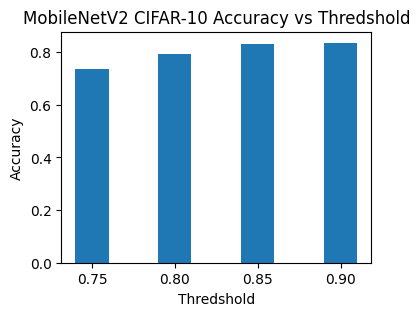

In [19]:
# Accu with thredshold
plt.figure(figsize=(4,3))
# bar 

bar_keys = [str(x) for x in range(4)]
bar_values = [mobile_cifar_gate_accuracy_075[0]/len(test), 
              mobile_cifar_gate_accuracy_080[0]/len(test), 
              mobile_cifar_gate_accuracy_085[0]/len(test), 
              mobile_cifar_gate_accuracy_090[0]/len(test)]

plt.bar(bar_keys, bar_values, width=0.4)

plt.title('MobileNetV2 CIFAR-10 Accuracy vs Thredshold')
plt.xlabel('Thredshold')
plt.xticks(np.arange(4), ['0.75', '0.80', '0.85', '0.90'])
plt.ylabel('Accuracy')
plt.show()

In [37]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
from Models import resnet
from Dataloaders import dataloader_image_20
device = 'cuda:0'
width = 56
height = 56
threshold = 0.8
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255

def normalize(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    return (x - x_min)/(x_max - x_min)

def normalize_return(x):
    x_min = torch.min(x)
    x_max = torch.max(x)
    return (x - x_min)/(x_max - x_min), x_min, x_max

def renormalize(x, x_min, x_max):
    return x * (x_max - x_min) + x_min

import torch
import numpy as np
resnet_imagenet_gate_frequency_080 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_080 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target, _) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        print(data[0,0,0])
        out = client(data).detach()
        print(out[0,0,0])
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_080[j] += 1

                middle_out1 = middle_out.clone()
                middle_out2 = middle_out.clone()
                
                middle_out, outmin, outmax = normalize_return(middle_out)
                # print(outmax, outmin)
                # print(middle_out[0,0,0])
                middle_out = float_to_uint(middle_out)

                print(middle_out[0,0,0])
                print(j)
                print(outmax, outmin)
                sys.exit()

                # print(middle_out[0,0,0])
                middle_out = uint_to_float(middle_out)
                # print(middle_out[0,0,0])
                middle_out = renormalize(middle_out, outmin, outmax)
                # print(middle_out[0,0,0])

                middle_out1 = float_to_uint(middle_out1)
                middle_out1 = uint_to_float(middle_out1)

                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_080[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_080 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_080)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_080/len(test)) 


  0%|          | 0/5087 [00:00<?, ?it/s]

tensor([-1.4329, -1.3473, -1.1932, -1.1932, -0.7137, -0.6281, -1.0562, -0.9705,
        -0.8849, -1.1075, -0.9877, -0.9363, -1.0390, -1.0904, -0.9877, -0.6452,
        -0.5082, -0.2513, -0.2684, -0.6965, -0.3541,  0.0741, -0.3712, -0.2856,
        -0.3883, -0.2171, -0.7137, -0.6281, -0.5082, -0.9877, -0.6281, -0.9877,
        -0.7650, -1.2617, -1.4329, -1.5528, -1.5528, -1.4672, -1.3987, -1.2788,
        -1.2274, -1.2788, -1.2617, -0.7479, -0.5938, -0.2856, -0.4054, -0.0287,
        -0.4911, -0.7822, -0.2856,  0.1768,  0.1597,  0.2453,  0.3823, -0.0629,
        -0.5767, -1.0219, -1.1247, -1.1247, -1.2103, -1.5014, -1.5699, -1.5357,
        -1.5699, -1.6042, -1.5357, -1.4158, -1.4158, -1.3815, -1.3130, -1.2617,
        -0.9705, -0.7993, -0.8849, -0.9877, -1.0562, -1.1075, -1.0904, -0.9705,
        -0.7308, -0.4226, -0.1486, -0.0116, -0.0116, -0.2513, -0.7650, -0.8335,
        -1.0733, -0.7993,  0.2453,  0.8961,  0.9988,  1.0331,  0.9817,  0.9646,
         0.6392,  0.6221,  0.3138,  0.72

SystemExit: 

100%|██████████| 5087/5087 [00:39<00:00, 128.65it/s]


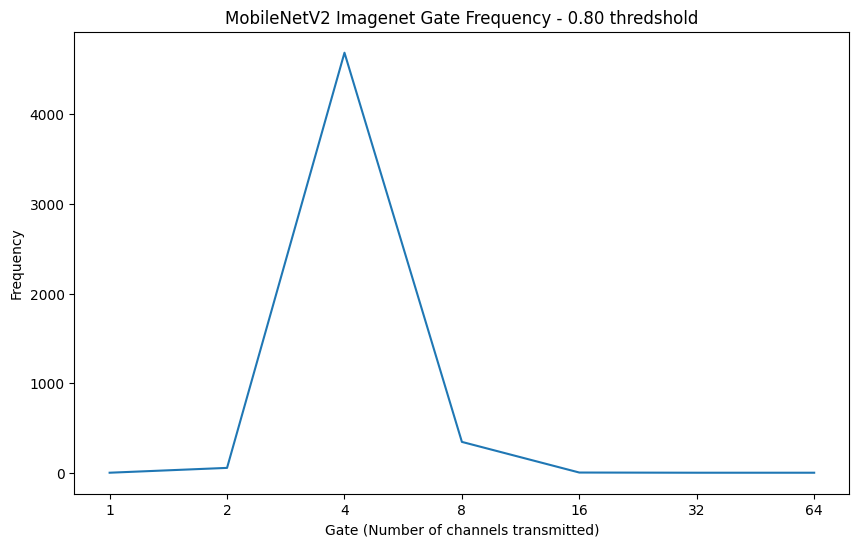

Accuracy: [0.74798506]


In [21]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
threshold = 0.75
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_075 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_075 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target, _) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_075[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_075[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_075 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_075)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_075/len(test)) 


In [22]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
threshold = 0.85
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_085 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_085 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target, _) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_085[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_085[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_085 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_085)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_085/len(test)) 


  4%|▍         | 219/5087 [00:01<00:38, 124.97it/s]


KeyboardInterrupt: 

100%|██████████| 5087/5087 [01:26<00:00, 59.12it/s]


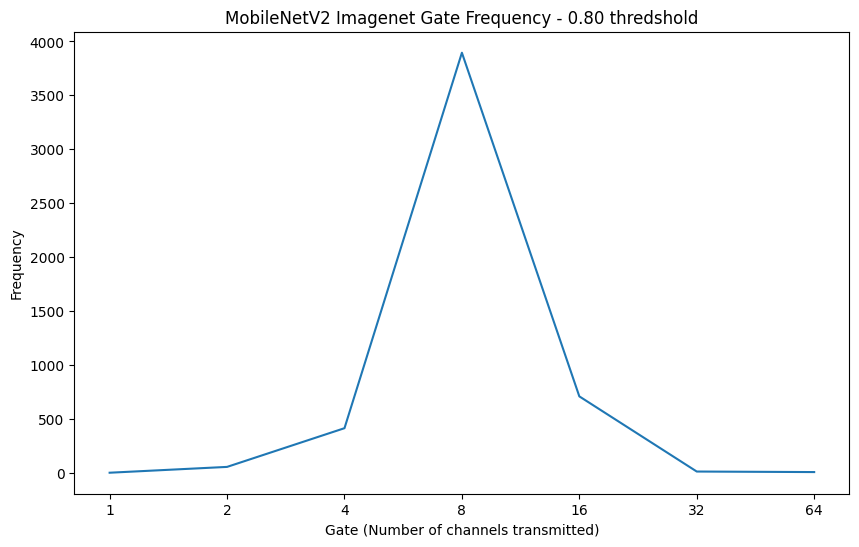

Accuracy: [0.82897582]


In [ ]:
# dataset = 'imagenet', model = resnet, exit rate vs gate
device = 'cuda:0'
width = 56
height = 56
threshold = 0.90
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)
from Models import gatedmodel
gate_models = []
for i in range (len(middle_size_resnet)):
    gate = gatedmodel.ExitGate(in_planes=middle_size_resnet[i], width=width, height=height)
    gate.load_state_dict(torch.load(
        './Weights/imagenet/gate/resnet_imagenet_gate_%s.pth'%str(middle_size_resnet[i])))
    gate_models.append(gate)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)
for gate in gate_models:
    gate = gate.eval().to(device)

gate_results = [] # exit rate here
for i in range(len(gate_models)):
    gate_results.append([])

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)
for gate in gate_models:
    gate = torch.ao.quantization.quantize_dynamic(gate, dtype=torch.qint8)

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255
import torch
import numpy as np
resnet_imagenet_gate_frequency_090 = np.zeros(len(gate_models)+1)
resnet_imagenet_gate_accuracy_090 = 0
with torch.no_grad():
    # get the conf for each middles
    for i, (data, target, _) in enumerate(tqdm(test)):
        data, target = data.to(device), target.to(device)
        out = client(data).detach()
        exit_flag = False
        for j in range(len(gate_models)):
            middle_out = middle_models[j].in_layer(out)
            gate_out = gate_models[j](middle_out)
            if gate_out>threshold:
                resnet_imagenet_gate_frequency_090[j] += 1
                middle_out = float_to_uint(middle_out)
                middle_out = uint_to_float(middle_out)
                out = middle_models[j].out_layer(middle_out)

                exit_flag = True
                break
        if not exit_flag:
            resnet_imagenet_gate_frequency_090[-1] += 1
            out = float_to_uint(out)
            out = uint_to_float(out)

        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        out = out.max(dim=1)[1]
        out = out == target
        resnet_imagenet_gate_accuracy_090 += out.cpu().numpy()
        
# get the conf for the server
# plot gate frequency
plt.figure(figsize=(10, 6))
plt.plot([str(x) for x in middle_size_resnet.values()] + [str(2*list(middle_size_resnet.values())[-1])], resnet_imagenet_gate_frequency_090)
plt.title('MobileNetV2 Imagenet Gate Frequency - 0.80 thredshold')
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
plt.show()

# plot accuracy
print('Accuracy:', resnet_imagenet_gate_accuracy_090/len(test)) 


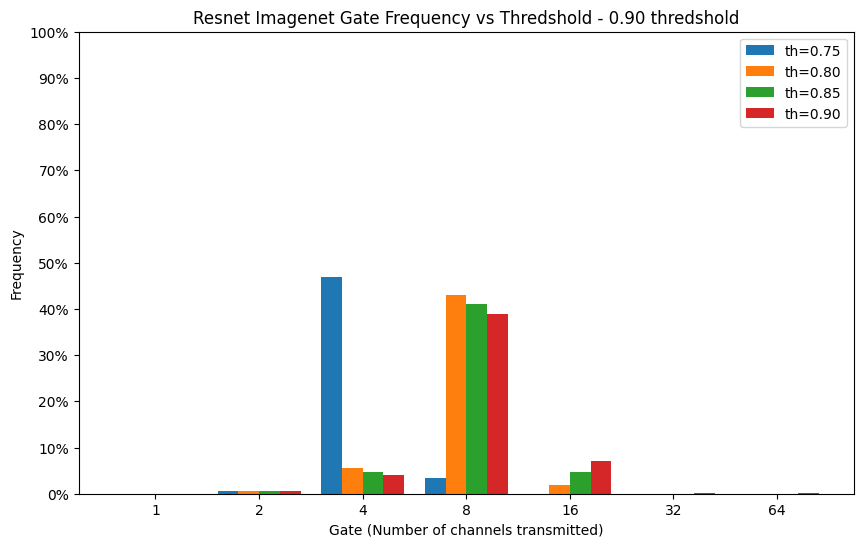

In [ ]:
# plot a single image
plt.figure(figsize=(10, 6))
plt.bar([x-0.3 for x in range(len(middle_size_resnet.values())+1)], resnet_imagenet_gate_frequency_075, label='th=0.75', width=0.2)
plt.bar([x-0.1 for x in range(len(middle_size_resnet.values())+1)], resnet_imagenet_gate_frequency_080, label='th=0.80', width=0.2)
plt.bar([x+0.1 for x in range(len(middle_size_resnet.values())+1)], resnet_imagenet_gate_frequency_085, label='th=0.85', width=0.2)
plt.bar([x+0.3 for x in range(len(middle_size_resnet.values())+1)], resnet_imagenet_gate_frequency_090, label='th=0.90', width=0.2)

plt.title('Resnet Imagenet Gate Frequency vs Thredshold - %.2f thredshold'%threshold)
plt.xlabel('Gate (Number of channels transmitted)')
plt.ylabel('Frequency')
# chagne 0-10000 to 0-1
plt.yticks(np.arange(0, 10001, 1000), [str(x*10)+'%' for x in range(11)])

plt.xticks(np.arange(len(middle_size_resnet.values())+1), [str(x) for x in middle_size_resnet.values()]+ [str(2*list(middle_size_resnet.values())[-1])])
plt.legend()
plt.show()

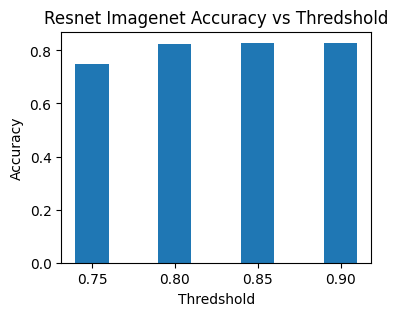

In [ ]:
# Accu with thredshold
plt.figure(figsize=(4,3))
# bar 

bar_keys = [str(x) for x in range(4)]
bar_values = [resnet_imagenet_gate_accuracy_075[0]/len(test), 
              resnet_imagenet_gate_accuracy_080[0]/len(test), 
              resnet_imagenet_gate_accuracy_085[0]/len(test), 
              resnet_imagenet_gate_accuracy_090[0]/len(test)]

plt.bar(bar_keys, bar_values, width=0.4)

plt.title('Resnet Imagenet Accuracy vs Thredshold')
plt.xlabel('Thredshold')
plt.xticks(np.arange(4), ['0.75', '0.80', '0.85', '0.90'])
plt.ylabel('Accuracy')
plt.show()

Files already downloaded and verified
Files already downloaded and verified


 10%|█         | 1000/10000 [00:07<01:08, 131.19it/s]


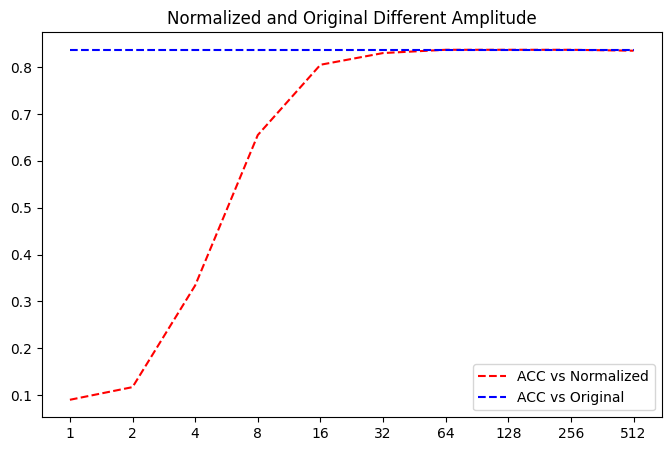

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(10)]

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10,
                                                  weight_root='./Weights/cifar-10')
client = client.eval()
server = server.eval()
client.to(device)
server.to(device)

accuracy = [0] * len(amp_list)
orig_acc = 0

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    for j in range (len(amp_list)):

        client_out = client(data).detach() # 1, c', h, w

        amp = 2**j

        client_out_max = torch.max(client_out)
        client_out_min = torch.min(client_out)
        client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
        client_out = client_out*amp
        # change it to int
        client_out = client_out.long()

        client_out = client_out.float()/amp
        client_out = client_out*(client_out_max-client_out_min)+client_out_min

        pred = server(client_out).detach()
        pred = torch.argmax(pred, dim=1)
        pred_acc = torch.sum(pred == label).item()
        accuracy[j] += pred_acc
    
    if i == 1000:
        break

for i, (data, label) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(8,5))
for i in range(len(amp_list)):
    accuracy[i] = accuracy[i]/1000
plt.plot(amp_list, accuracy, 'r--', label='ACC vs Normalized')
plt.plot(amp_list, [orig_acc/1000]*len(amp_list), 'b--', label='ACC vs Original')
plt.xticks(amp_list, [2**x for x in amp_list])
plt.plot()
plt.legend()
plt.title('Normalized and Original Different Amplitude')

plt.show()
# we can choose 64 and 128

 20%|█▉        | 1000/5087 [00:11<00:46, 87.50it/s]


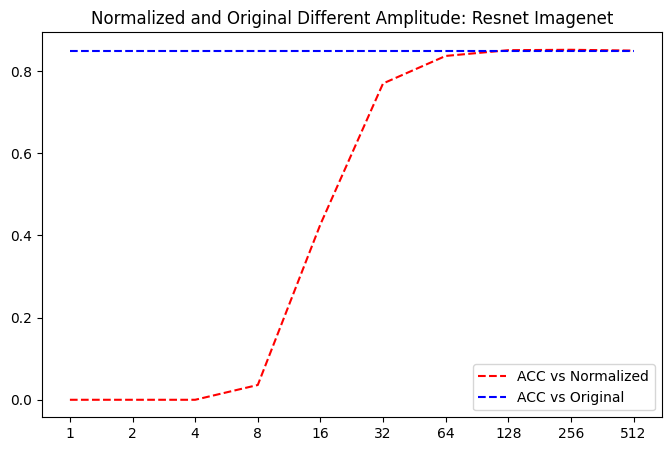

In [ ]:
# change the data type

# dataset = 'cifar10', model = mobile, accuracy vs data type
# can we change the value after normalization from 0-max to 0-16
from tqdm import tqdm
# get the number of zeros and positions
norm_acc = []
orig_acc = []

amp_list = [x for x in range(10)]

_, test, _, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)
client, server = resnet.resnet_splitter(num_classes=1000,
                                        weight_root='./Weights/imagenet',
                                        layers=50)
client = client.eval()
server = server.eval()
client.to(device)
server.to(device)

accuracy = [0] * len(amp_list)
orig_acc = 0

for i, (data, label, _) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    for j in range (len(amp_list)):

        client_out = client(data).detach() # 1, c', h, w

        amp = 2**j

        client_out_max = torch.max(client_out)
        client_out_min = torch.min(client_out)
        client_out = (client_out-client_out_min)/(client_out_max-client_out_min)
        client_out = client_out*amp
        # change it to int
        client_out = client_out.long()

        client_out = client_out.float()/amp
        client_out = client_out*(client_out_max-client_out_min)+client_out_min

        pred = server(client_out).detach()
        pred = torch.argmax(pred, dim=1)
        pred_acc = torch.sum(pred == label).item()
        accuracy[j] += pred_acc
    
    if i == 1000:
        break

for i, (data, label, _) in enumerate(tqdm(test)):
    data, label = data.to(device), label.to(device)

    client_out = client(data).detach() # 1, c', h, w

    pred = server(client_out).detach()
    pred = torch.argmax(pred, dim=1)
    pred_acc = torch.sum(pred == label).item()
    orig_acc += pred_acc

    if i == 1000:
        break
plt.figure(figsize=(8,5))
for i in range(len(amp_list)):
    accuracy[i] = accuracy[i]/1000
plt.plot(amp_list, accuracy, 'r--', label='ACC vs Normalized')
plt.plot(amp_list, [orig_acc/1000]*len(amp_list), 'b--', label='ACC vs Original')
plt.xticks(amp_list, [2**x for x in amp_list])
plt.plot()
plt.legend()
plt.title('Normalized and Original Different Amplitude: Resnet Imagenet')

plt.show()
# we can choose 64 and 128